# Étude de faisabilité

In [1]:
# Importations
import pandas as pd
import numpy as np

## Chargement et nettoyage des données

In [2]:
# Chargement des données
data = pd.read_csv("cleaned.csv")
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Pour commencer, on sélectionne uniquement les colonnes qui nous intéressent, à savoir l'id du produit, sa description et sa catégorie.

In [3]:
data = data[["uniq_id", "product_category_tree", "description"]]

La colonne 'product_category_tree' affiche une arborescence complète de la catégorie du produit. Il va donc falloir extraire uniquement le nom de la catégorie à partir de cette arborescence.

In [4]:
def extract_category(category_tree: str) -> str:
    """Le dernier élément de l'arborescence correspond au nom du
    produit lui-même : on le supprime donc"""
    splitted_category = category_tree.strip('[]"').split(">>")
    return splitted_category[0].strip()

data["category"] = data["product_category_tree"].apply(extract_category)
print(data["category"].value_counts())

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: category, dtype: int64


On constate que la distribution des produits dans les différentes catégories est homogène : nous n'aurons donc pas à rééquilibrer les classes.

## Vectorisation des features

Maintenant, il va nous falloir vectoriser nos descriptions de produit ainsi que nos images. On pourra par la suite simplement concaténer ces deux vecteurs pour obtenir le vecteur d'entrée qui nourrira notre modèle de clustering, et plus tard notre classificateur.

### Vectorisation des descriptions de produit

Pour commencer, on code une fonction pour nettoyer le texte des descriptions et le séparer en tokens.

In [5]:
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text: str):
    """Supprime les accents et les stopwords, tokenize, lemmatize le texte"""
    clean_text = gensim.utils.simple_preprocess(text)
    filtered_sentence = []
  
    for w in clean_text:
        if w.lower() not in stop_words:
            lem = lemmatizer.lemmatize(w.lower()) 
            filtered_sentence.append(lem)       

    return filtered_sentence

data["description_tokenized"] = data["description"].apply(preprocess_text)
print(data["description_tokenized"].head())


0    [key, feature, elegance, polyester, multicolor...
1    [specification, sathiyas, cotton, bath, towel,...
2    [key, feature, eurospa, cotton, terry, face, t...
3    [key, feature, santosh, royal, fashion, cotton...
4    [key, feature, jaipur, print, cotton, floral, ...
Name: description_tokenized, dtype: object


Plusieurs techniques sont possibles pour vectoriser notre texte de description. Ici, nous allons coder des fonctions qui permettent de vectoriser notre texte selon différentes techniques. Par la suite, nous testerons ces différentes méthodes de vectorisation en combinaison avec nos images vectorisées pour déterminer quelles sont les méthodes les plus performantes. Mais dans un premier temps, contentons-nous de définir toutes les fonctions dont nous aurons besoin plus tard :

#### Count Vectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


def count_vectorizer(X) -> np.array:
    """X: itérable qui contient des
    listes de tokens
    Renvoit une matrice BOW"""

    X_ = list(X)
    for i in range(len(X_)):
        X_[i] = " ".join(X_[i])
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(X_).toarray()


#### TF-IDF

In [7]:
def tfidf_vectorizer(X) -> np.array:
    """X: itérable qui contient des
    listes de tokens
    Renvoit une matrice BOW"""
    
    X_ = list(X)
    for i in range(len(X_)):
        X_[i] = " ".join(X_[i])

    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X_).toarray()


    

#### Doc2vec

In [24]:
import collections

def doc2vec_vectorizer(X) -> tuple:
    """X: itérable qui contient des listes
    de tokens. Renvoit un np.array"""


    ###############################################
    # Préparation des sets d'entraînement et de test
    X_ = list(X)

    train_corpus = []
    #test_corpus = []

    train_tokens = X_
    #train_tokens = X_[:int(0.8*len(X_))]
    #test_tokens = X_[int(0.8*len(X_)):]

    for desc_index in range(len(train_tokens)): 
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(train_tokens[desc_index], [desc_index]))
    
    #test_corpus = test_tokens
    ###############################################

    ###############################################
    # Entraînement du modèle

    model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

    ###############################################

    ###############################################
    # Évaluation du modèle
    # Pour vérifier la validité du modèle, on regarde s'il est précis sur le dataset
    # d'entraînement, pour commencer
    ranks = []
    second_ranks = []
    embedding_vectors = []
    for doc_id in range(len(train_corpus)):
        inferred_vector = model.infer_vector(train_corpus[doc_id].words)
        embedding_vectors.append(inferred_vector)
        sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)

        second_ranks.append(sims[1])

    counter = collections.Counter(ranks)
    
    # On calcule l'accuracy du modèle Word2vec, i.e. la proportion
    # de textes de description dont le vecteur prédit par le modèle
    # est le plus proche de leur vecteur réel

    accuracy = counter[0]/len(X_)

    return (np.array(embedding_vectors), accuracy)
    

results = doc2vec_vectorizer(data["description_tokenized"])
vectors = results[0]
accuracy = results[1]
print(f"Accuracy de doc2vec: {accuracy * 100} %")


Accuracy de doc2vec: 70.85714285714285 %


On remarque que le modèle Doc2vec prédit un vecteur proche du vecteur réel des descriptions dans 67 % des cas uniquement. Cela est probablement dû à la mauvaise qualité générale des descriptions, qui comportent beaucoup de mots sans rapport avec le produit. Pour pallier à ce problème, nous essaierons plus tard de remplacer la description des produits par leur nom pour voir si cela améliore les performances.

#### fastText (pas fini)

In [9]:
def fastText_vectorizer(X) -> tuple:

    X_ = list(X)
    train_corpus = []

    """for desc_index in range(len(X_)): 
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(X_[desc_index], [desc_index]))"""
    train_corpus = X_
    print(train_corpus)

    model = gensim.models.FastText(vector_size=50, min_count=2, epochs=40)
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=len(train_corpus), epochs=model.epochs)

    ###############################################
    # Évaluation du modèle
    # Pour vérifier la validité du modèle, on regarde s'il est précis sur le dataset
    # d'entraînement, pour commencer   

    ranks = []
    second_ranks = []
    embedding_vectors = []
    for doc_id in range(len(train_corpus)):
        #inferred_vector = model.wv[train_corpus[doc_id].words]
        inferred_vector = model.wv[train_corpus[doc_id]]
        
        ######################################################
        # ATTENTION : apparemment fastText crée un vecteur par token, à vérifier
        # Essayer de faire une moyenne de tous les vecteurs pour avoir un
        # vecteur qui représente une description entière
        ######################################################
        print(inferred_vector)
        embedding_vectors.append(inferred_vector)
        sims = model.wv.most_similar([inferred_vector], topn=len(model.wv))
        rank = [docid for docid, sim in sims].index(doc_id)
        ranks.append(rank)

        second_ranks.append(sims[1])

    counter = collections.Counter(ranks)
    accuracy = counter[0]/len(X_)
    return (embedding_vectors, accuracy)

results = fastText_vectorizer(data["description_tokenized"])
vectors = results[0]
accuracy = results[1]
print(f"Accuracy de doc2vec: {accuracy * 100} %")
    


[['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'softly', '

ValueError: non-broadcastable output operand with shape (50,) doesn't match the broadcast shape (152,50)

### Vectorisation des images

Pour commencer, on ajoute dans notre dataframe une colonne qui contient le chemin vers l'image correspondante à chaque produit.

In [10]:
def add_images_column(unique_id: str) -> str:
    return "Images/" + unique_id + ".jpg" 

data["image_path"] = data["uniq_id"].apply(add_images_column)
if "product_category_tree" in data.columns: data.drop(columns=["product_category_tree"], inplace=True)
data.to_csv("ready_to_use_data.csv")

Dans les cellules ci-dessous, on code des fonctions qui nous permettront de faire du clustering sur nos images avec différentes méthodes d'extraction de features. Ces fonctions seront utilisées plus tard pour comparer les différentes techniques et choisir la meilleure.

#### SIFT

On commence par installer les modules nécessaires et afficher les descripteurs pour une image du dataset afin de vérifier que tout fonctionne bien.

In [11]:
!pip3 install opencv-python
!pip3 install opencv-contrib-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


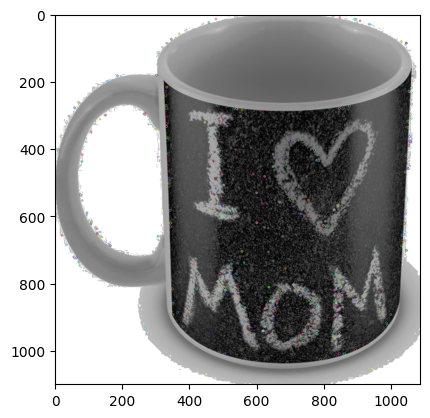

Descripteurs :  (500, 128)

[[30.  4. 28. ...  0.  0.  3.]
 [ 6.  4. 13. ...  0.  0.  0.]
 [46.  1.  0. ... 40. 17.  5.]
 ...
 [ 2.  8. 19. ...  0.  0.  0.]
 [ 4.  5.  2. ...  2.  0.  0.]
 [ 2.  0.  0. ...  1.  0.  1.]]


In [12]:
import cv2
import matplotlib.pyplot as plt

def display_descriptors(img_path: str):

    sift =  cv2.SIFT_create(500)
    image = cv2.imread(img_path, 0) # convert in gray
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    img=cv2.drawKeypoints(image,kp,image)
    plt.imshow(img)
    plt.show()
    print("Descripteurs : ", des.shape)
    print()
    print(des)

display_descriptors(data["image_path"].iloc[45])

On code ensuite une fonction qui sera utilisée pour calculer les descripteurs pour chaque image.

In [13]:
sift =  cv2.SIFT_create(500) # On limite à 500 features pour l'instant

def sift_compute_descriptors(img_path: str, img_num: int):

    if img_num % 100 == 0: print(f"{img_num} images processed")
    image = cv2.imread(img_path, 0) # convert in gray
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(image, None)
    return des

sift_keypoints = []
img_list = list(data["image_path"])
for i in range(len(img_list)):
    sift_keypoints.append(sift_compute_descriptors(img_list[i], i))

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)
print(sift_keypoints_by_img)


0 images processed


KeyboardInterrupt: 

In [ ]:
# On enregistre les résultats de SIFT au cas où
import pickle

with open("pickles/sift_keypoints_by_img.pkl", 'wb') as file:
    pickle.dump(sift_keypoints_by_img, file)

with open("pickles/sift_keypoints_all.pkl", 'wb') as file:
    pickle.dump(sift_keypoints_all, file)

print(sift_keypoints_all)

[[ 77.  77.   0. ...   0.   1.  18.]
 [  1.   2.   1. ...   2.   0.   0.]
 [  7.   0.   0. ...   0.   0.  19.]
 ...
 [  3.  28. 123. ...   0.   0.   2.]
 [  0.   0.   0. ...  21.  56.  35.]
 [ 21.  98.  22. ...   0.   0.   4.]]


In [ ]:
!pip3 install --upgrade threadpoolctl

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


#### ORB

In [52]:
import cv2
orb = cv2.ORB_create(300)

def orb_compute_descriptors(img_path: str, img_num: int):

    if img_num % 100 == 0: print(f"{img_num} images processed")
    image = cv2.imread(img_path, 0) # convert in gray
    image = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = orb.detectAndCompute(image, None)
    return des

orb_keypoints = []
img_list = list(data["image_path"])
for i in range(len(img_list)):
    orb_keypoints.append(orb_compute_descriptors(img_list[i], i))

orb_keypoints_by_img = np.asarray(orb_keypoints)
orb_keypoints_all = np.concatenate(orb_keypoints_by_img, axis=0)



0 images processed
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed


/tmp/ipykernel_16635/638188834.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  orb_keypoints_by_img = np.asarray(orb_keypoints)


In [54]:
test = np.concatenate(orb_keypoints_by_img, axis=0)
for i in orb_keypoints_by_img: print(i.shape)

(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(305, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(296, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)
(300, 32)


In [18]:
import pickle

with open("pickles/orb_keypoints_by_img.pkl", 'wb') as file:
    pickle.dump(orb_keypoints_by_img, file)

with open("pickles/orb_keypoints_all.pkl", 'wb') as file:
    pickle.dump(orb_keypoints_all, file)


### Fusion des vecteurs d'image et des vecteurs texte

Jusque-là, nous avons travaillé sur les images et le texte séparément. Cependant, notre objectif final reste d'obtenir un vecteur unique par produit, auquel on pourra appliquer un modèle de clustering, puis éventuellement de classification (plus tard). Pour atteindre cet objectif, une solution simple est retenue : pour chaque produit, **on concaténera le vecteur de l'image et celui de la description**.

Dans la mesure où nous avons essayé différentes techniques de vectorisation, notre objectif ici sera de tester toutes les combinaisons de techniques possibles afin de déterminer la meilleure (exemples : ORB et TF-IDF, SIFT et CountVectorizer...)

In [28]:
# Collecte de tous les vecteurs générés jusque-là
word_vectors = {
    "count vectorizer": count_vectorizer(data["description_tokenized"]),
    "TF_IDF": tfidf_vectorizer(data["description_tokenized"]),
    "Doc2Vec": doc2vec_vectorizer(data["description_tokenized"])[0]
}

image_vectors = {}

with open("pickles/sift_keypoints_by_img.pkl", 'rb') as file:
    image_vectors["SIFT"] = pickle.load(file)
with open("pickles/orb_keypoints_by_img.pkl", 'rb') as file:
    image_vectors["ORB"] = pickle.load(file)

for i in word_vectors: 
    print(i)
    print(word_vectors[i])

for i in image_vectors: 
    print(i)
    print(image_vectors[i])

count vectorizer
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
TF_IDF
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Doc2Vec
[[-0.66695184  1.202082    1.8377275  ...  1.8257803  -1.6030803
   2.176251  ]
 [-0.01562851 -0.08776855  1.039972   ... -0.05916346 -0.1309083
   0.6823135 ]
 [ 0.37214002 -0.40485266  0.91650045 ...  0.15474345 -0.01792764
   1.4865677 ]
 ...
 [ 0.28217778 -0.0495142   1.1281084  ... -0.2988572  -0.09199317
   0.09930791]
 [-0.07297054  0.13383344  0.2342612  ...  0.09002948 -0.04433127
   0.1718002 ]
 [-0.00805997  0.05440583  0.42464766 ... -0.0682101  -0.00914338
   0.27915564]]
SIFT
[array([[77., 77.,  0., ...,  0.,  1., 18.],
        [ 1.,  2.,  1., ...,  2.,  0.,  0.],
        [ 7.,  0.,  0., ...,  0.,  0., 19.],
        ...,
        [24.,  9.,  1., ...,  1.,  0.,  0.],
    

In [65]:
print(np.concatenate(image_vectors["SIFT"], axis=1))

def merge_vectors(word_vec: np.array, img_vec: np.array):
    return np.concatenate([word_vec, img_vec])

print(word_vectors["count vectorizer"].shape)
print(image_vectors["SIFT"].shape)
print(merge_vectors(word_vectors["count vectorizer"], image_vectors["ORB"]).shape)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 500 and the array at index 5 has size 501

In [69]:
def extract_data(data):

    v = np.column_stack(data["test"].values.tolist())
    df = pd.DataFrame(v).T

    return df

data["test"] = word_vectors["TF_IDF"]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
        0
0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
...   ...
1045  0.0
1046  0.0
1047  0.0
1048  0.0
1049  0.0

[1050 rows x 1 columns]
